In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from scipy import signal
from sklearn.linear_model import LinearRegression
plt.rcParams['pdf.fonttype'] = 42


In [34]:
def Mphase_detection(ys):
    n_time = len(ys)
    ys = [cmp for cmp in ys]
    diffs = np.zeros((n_time,))
    for i in range(n_time - 1):
        diffs[i] = ys[i+1] - ys[i]
    min_dif = min(diffs)
    frame_min = np.argmin(diffs)
    if diffs[frame_min - 1] < 0:
        frame_min = frame_min-1

    return frame_min, diffs

minimum_length = 20        # データレトリーブするときにこれ以下の長さの時系列は捨てる
minimum_cdk_peak = {"HS007": 1.7}      # ピークと検出されるために最低限必要なratio値
interval = 5        # 撮影間隔

dirs = sorted(glob.glob("./dir_HS*"))

data_stats = pd.DataFrame({})  # 分裂から分裂までの時間とか，時系列データじゃないデータを格納するdata frame
data_div_to_div = pd.DataFrame()     # 分裂から分裂までの時系列データを格納
data_tot_hm = pd.DataFrame({})
for dir_name in dirs:
    data_plot = pd.DataFrame({})
    data_plot_line = pd.DataFrame({})

    strain_name = dir_name[6:]

    # 各strainのデータを読み込む
    data_all = pd.read_csv(dir_name + "/_results.csv")
    lineage_org = data_all[" Lineage"].unique().tolist()  # 元データのLineage列に含まれる文字列： [ a_..._z ]を重複なく抜き出す

    # 個別のlineageとして全データをレトリーブする
    data_container1 = {}
    data_container2 = {}
    for cmp in lineage_org:
        df_RFP = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C0"]
        df_FRET = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C1"]
        df_CFP = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C2"]
        df_ratio = df_FRET / df_CFP
        data_container1[cmp[2:-2]] = df_ratio  # 元の[ a_..._z ]ではなく，a_..._zを抜き出して辞書data_containerに格納
        data_container2[cmp[2:-2]] = df_RFP  # 元の[ a_..._z ]ではなく，a_..._zを抜き出して辞書data_containerに格納
    container_keys = sorted(data_container1.keys(), reverse=True)
    for cmp in container_keys:
        if cmp[-2:] != "_2":  # 末尾に_2がついてるやつのみ処理する
            continue
        # xxx_2 vs xxx_1を比べて長くトラッキングできてるほうを根元の時系列データにつなげる
        if len(data_container1[cmp]) > len(data_container1[cmp[:-2] + "_1"]):
            data_container1[cmp[:-2]] = pd.concat([data_container1[cmp[:-2]], data_container1[cmp]],
                                                 ignore_index=True)
            data_container2[cmp[:-2]] = pd.concat([data_container2[cmp[:-2]], data_container2[cmp]],
                                                  ignore_index=True)
        else:
            data_container1[cmp[:-2]] = pd.concat([data_container1[cmp[:-2]], data_container1[cmp[:-2] + "_1"]],
                                                 ignore_index=True)
            data_container2[cmp[:-2]] = pd.concat([data_container2[cmp[:-2]], data_container2[cmp[:-2] + "_1"]],
                                                 ignore_index=True)

    # 上の操作によって" _ "のついていない根元の細胞から辿れた最大のトラッキングデータが繋げられている
    lineages_ratio = pd.DataFrame({})  # ここに統合した最長のcell lineageのdf-ratioを格納していく．
    lineages_RFP = pd.DataFrame({})  # ここに統合した最長のcell lineageのdf-RFPを格納していく．
    for cmp in container_keys:
        if "_" in cmp:  # origin cellじゃなければ処理しない
            continue
        if len(data_container1[cmp]) < minimum_length:  # 一定の長さ以下の細胞は見ても仕方がないので除く．
            continue
        temp = pd.DataFrame({cmp: [k for k in data_container1[cmp]]})
        lineages_ratio = pd.concat([lineages_ratio, temp], axis="columns")

        temp = pd.DataFrame({cmp: [k for k in data_container2[cmp]]})
        lineages_RFP = pd.concat([lineages_RFP, temp], axis="columns")

df_all = pd.DataFrame({})
count = 0
for cell in lineages_RFP:
    RFP_temp = lineages_RFP[cell]
    ratio_temp = lineages_ratio[cell]

    index, height = signal.find_peaks(ratio_temp, height=1.8, distance=25)
    
    if len(index) < 2:
        continue
    for k in range(len(index) - 1):
        start = index[k] - 6
        finish = index[k+1]+6
        if start >= 0 and finish <= len(RFP_temp) and finish-start>20:
            RFP = RFP_temp[start:finish]
            ratio = ratio_temp[start:finish]
            frame_min, diffs = Mphase_detection(ratio[:15])
            time = [(i -frame_min)*5 for i in range(len(RFP))]
            cellid = [str(cell) + "-" + str(k) for i in range(len(RFP))]
            temp = pd.DataFrame([time, ratio, RFP, cellid, [time[-1]+count/100 for i in range(len(RFP))]], index=["time", "ratio", "RFP", "id", "sort"])
            df_all = pd.concat([df_all, temp.T], ignore_index=True)
            count += 1
print(df_all)


     time     ratio          RFP    id    sort
0     -30  1.693252  1018.863014  87-0   180.0
1     -25  1.706989   1131.97973  87-0   180.0
2     -20  1.864054  1138.040268  87-0   180.0
3     -15   1.95474  1137.163399  87-0   180.0
4     -10  2.009378  1055.904762  87-0   180.0
...   ...       ...          ...   ...     ...
1544  195   1.97042  1516.091429   1-0  215.31
1545  200   1.94899  1501.798969   1-0  215.31
1546  205  1.573306       861.14   1-0  215.31
1547  210  1.462636   266.992754   1-0  215.31
1548  215  1.560207   131.669643   1-0  215.31

[1549 rows x 5 columns]


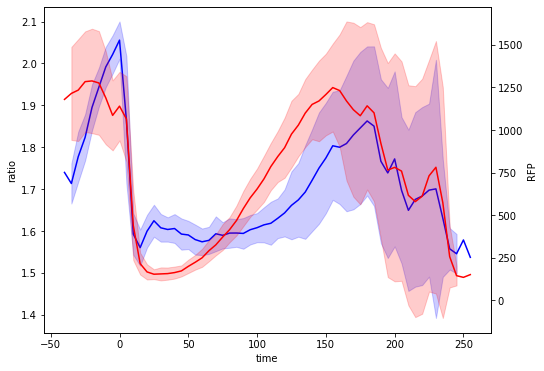

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax2 = ax.twinx()
sns.lineplot(x="time", y="ratio", data=df_all, ax=ax, ci="sd", color="blue")
sns.lineplot(x="time", y="RFP", data=df_all, ax=ax2, ci="sd", color="red")
plt.savefig("./__linear-plot_CDKEV-and-cdc13_2.png")
plt.savefig("./__linear-plot_CDKEV-and-cdc13_2.pdf")


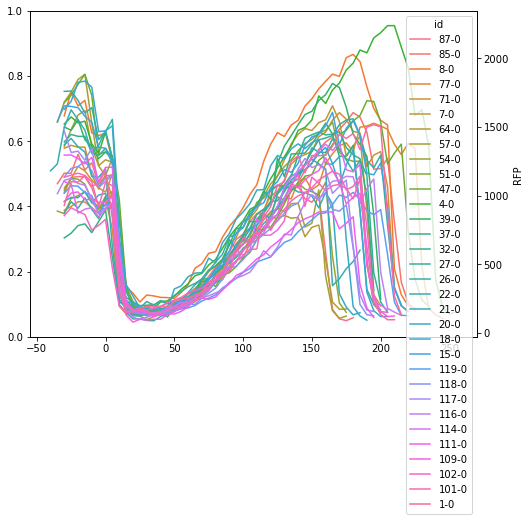

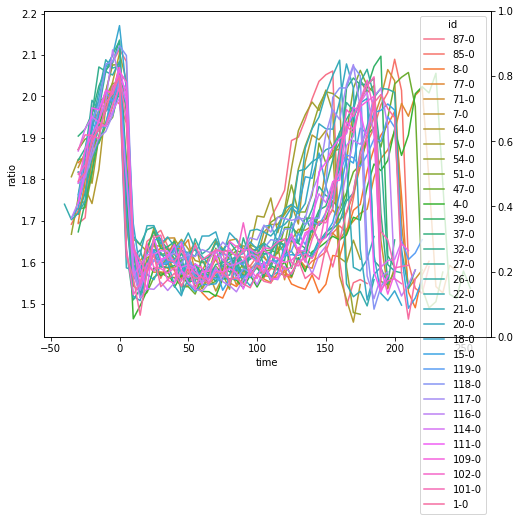

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax2 = ax.twinx()
#sns.lineplot(x="time", y="ratio", data=df_all, ax=ax, ci=None, estimator=None, hue="id", color="blue")
sns.lineplot(x="time", y="RFP", data=df_all, ax=ax2, ci=None, estimator=None, hue="id", color="red")
plt.savefig("./__linear-plot_cdc13-2_all.png")
plt.savefig("./__linear-plot_cdc13-2_all.pdf")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax2 = ax.twinx()
sns.lineplot(x="time", y="ratio", data=df_all, ax=ax, ci=None, estimator=None, hue="id", color="blue")
#sns.lineplot(x="time", y="RFP", data=df_all, ax=ax2, ci=None, estimator=None, hue="id", color="red")
plt.savefig("./__linear-plot_CDKEV2_all.png")
plt.savefig("./__linear-plot_CDKEV2_all.pdf")


Float64Index([200.05], dtype='float64', name='sort')

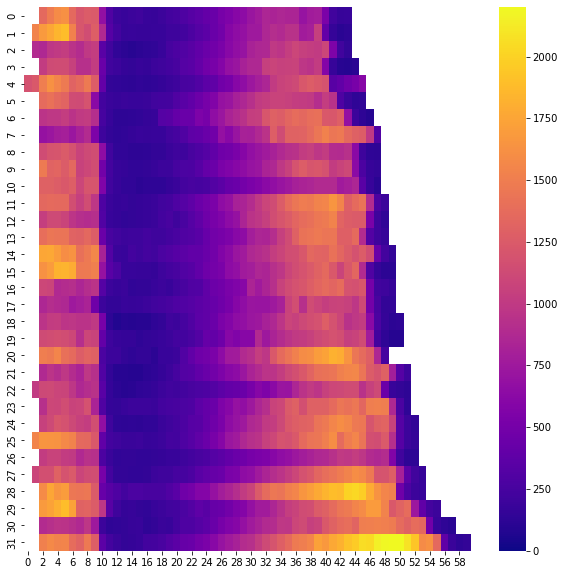

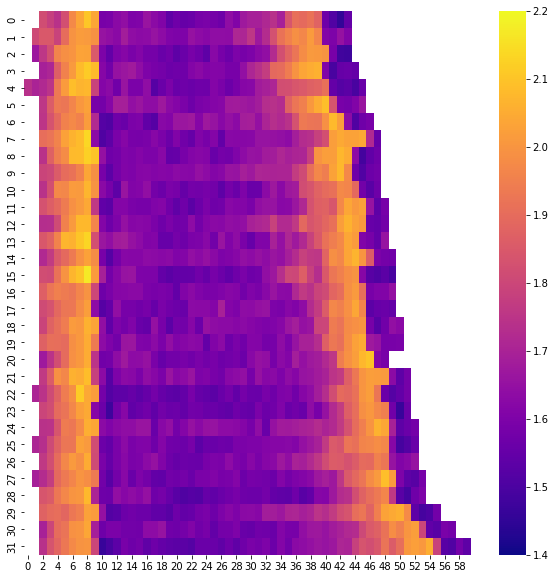

In [46]:
cmap = "plasma"
fig = plt.figure(figsize=(10, 10))
df_pivot = df_all.pivot(index="time", columns="sort", values="RFP")
sns.heatmap(df_pivot.values.astype(float).T, cmap=cmap, vmin=0, vmax=2200)
plt.savefig("./_heatmap_cyclin_2.png")
plt.savefig("./_heatmap_cyclin_2.pdf")

fig = plt.figure(figsize=(10, 10))
df_pivot = df_all.pivot(index="time", columns="sort", values="ratio")
sns.heatmap(df_pivot.values.astype(float).T, cmap=cmap, vmin=1.4, vmax=2.2)
plt.savefig("./_heatmap_CDK_2.png")
plt.savefig("./_heatmap_CDK_2.pdf")
LoI=[11]
display(df_pivot.columns[LoI])


Index(['1-0', '101-0', '102-0', '103-0', '109-0', '111-0', '114-0', '116-0',
       '117-0', '118-0', '119-0', '147-0', '15-0', '155-0', '17-0', '18-0',
       '20-0', '21-0', '26-0', '27-0', '32-0', '37-0', '39-0', '4-0', '47-0',
       '51-0', '54-0', '56-0', '57-0', '64-0', '7-0', '70-0', '71-0', '76-0',
       '77-0', '8-0', '85-0', '87-0', '92-0'],
      dtype='object', name='id')

<AxesSubplot:>

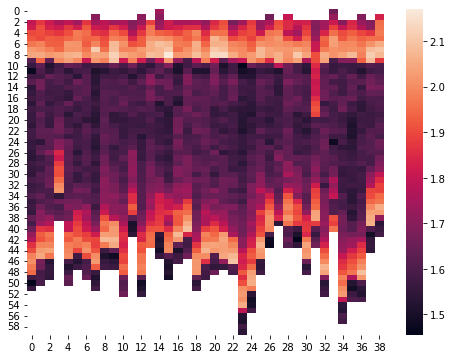

In [25]:
fig = plt.figure(figsize=(20, 6))
df_pivot = df_all.pivot(index="time", columns="id", values="ratio")
display(df_pivot.columns)
sns.heatmap(df_pivot.values.astype(float))